# Improving Montreal's BIXI Bikeshare System

In [47]:
#used libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import folium
from folium import plugins
import re
import math
from haversine import haversine, Unit
from datetime import datetime, date, time
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import namedtuple
import geopandas as gpd
from folium.plugins import HeatMap

### Why Bikeshare?

Bikeshare systems are an alternative form of public transport to traditional buses and subways which allow users to pick up and drop of shared bikes at specific stations around the city. The use of the bikeshare system has been increasing, making it an important feature to consider in the city's complete transport system. In the last year however it has begun to decrease; an improvement of the system may be able to bring usage back up. Biking is both more environmentally friendly and more healthy than automobiles, and incorporating this system is a benefit to the city's inhabitants. we thus want to analyse the system to see how people currenlty use the system and then find improvements to maximize and encourage the use of this beneficial form of transport. We especially want to analyse it with respect to it's interactions and incorportation with other tranport infrastructures. 

In [48]:
#load the bixi data
data = pd.read_pickle("../combined_new_stations")
stations = pd.read_pickle("../stations")

In [126]:
use = data.groupby(['year','start_station_code']).size().reset_index(name='counts')
use_dur = data[['year','start_station_code','duration_sec']].groupby(['year','start_station_code']).mean().reset_index()
use['duration'] = use_dur['duration_sec']

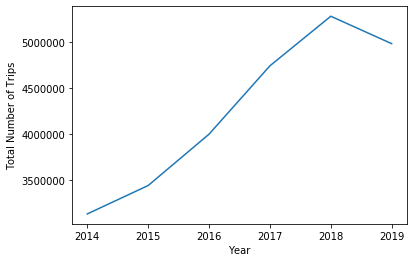

In [127]:
#total number of trips
trips = use.groupby('year').sum()
plt.plot(trips.index, trips.counts)
plt.ylabel('Total Number of Trips')
plt.xlabel('Year')
plt.show()

### Research Questions
1. Do the trips taken align with existing public transport lines or are they used to fill the gaps of the public transport routes?
2. Are some areas of Montreal more bike-friendly than others (i.e. have bike lanes or are smaller roads) and is this bike friendliness correlated with more trips done in that area?

# Datasets
To complete our analysis we worked with several different datasets:
1. BIXI Bikeshare trips (type = .csv, files = data for each year and month, station locations and codes for each year)
2. Montreal weather data (type = .csv, files = ...... )
3. Public transport schedule (type = , files = )
4. Bike paths (type = .geojson, files = )

Each of these datasets was treated in a different way in order to compile everything into a format where the data could be compared

### Bikeshare dataset

The first task was to combine the separate files for each year and month into a single dataframe. The station data (coordinates) was also merged and the dates converted to datetime and separated by year, month, day and hour for ease of analysis later. Additionally the 'distance' (more accurately displacement) of each trip was calculated using the haversine function (this is the straight line between the start and end station and does not reflect the actual distance traveled by the bike). 

The data was very clean already, with no NaNs, consistent formatting, and a reasonable looking distribution. We will focus on the data from 2019 for our analysis since public transport schedules and infrastructure, as well as the bike share infrastructure change each year, so in order to compare we need to look at a single year. For example the BIXI stations with the same code can change locations each year. The bus schedule also differs and bike lanes are added/demolished.

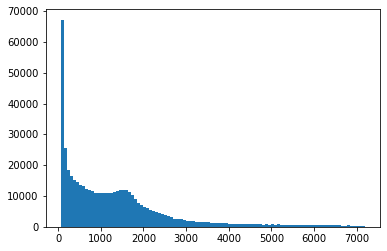

In [50]:
#round trip distribution
data_og = pd.read_pickle("../combined_data_old")
return_trip = data_og[data_og['distance']==0.0]
plt.hist(return_trip['duration_sec'], bins=100)
plt.show()

The above plot illustrates the distribution of return trips (start and end stations are the same). There is a disproportionately high number of trips which return to the same station at a very small duration. This is likely from broken bikes which are signed out but then returned very quickly to the same station. We thus decided to remove these data points, elminating any trips which returned to the same station and have a duration of less than 3 minutes. 

In [51]:
#2019 data only
data19 = pd.read_pickle("../combined2019")
data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,latitude_start,longitude_start,latitude_end,longitude_end,year,month,start_day,start_hour,end_day,end_hour
0,2014-04-15 00:01:00,6209,2014-04-15 00:18:00,6436,1061,1,45.512541,-73.570677,45.485801,-73.595797,2014,4,15,0,15,0
1,2014-04-15 00:01:00,6214,2014-04-15 00:11:00,6248,615,1,45.516091,-73.570129,45.518593,-73.581566,2014,4,15,0,15,0
2,2014-04-15 00:01:00,6164,2014-04-15 00:18:00,6216,1031,1,45.533314,-73.583737,45.514840,-73.584779,2014,4,15,0,15,0
3,2014-04-15 00:01:00,6214,2014-04-15 00:24:00,6082,1382,1,45.516091,-73.570129,45.549900,-73.583084,2014,4,15,0,15,0
4,2014-04-15 00:02:00,6149,2014-04-15 00:08:00,6265,347,1,45.538670,-73.569360,45.539259,-73.577459,2014,4,15,0,15,0


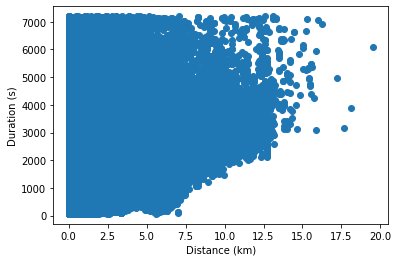

In [52]:
#raw data plot
plt.scatter(data19.distance, data19.duration_sec)
plt.ylabel('Duration (s)')
plt.xlabel('Distance (km)')
plt.show()

As expected the bottom right corner of the plot has no data points since there is a limit to how fast bikers can travel between two stations. 

# BIXI Bikeshare System

We first wanted to get a general idea of how the system was being used and what kind of trips were taken on it. We also looked at the setup, including distribution of stations across the city. 

In [ ]:
#distance vs duration for 2019 (all months)
sns.jointplot(data19.distance, data19.duration_sec, kind='hex', color="#4CB391")
plt.show()

In [ ]:
#time of day of usage (start of usage) vs days of the year (with overall histograms on the side)
plt.hist2d(data19.start_hour, data19.start_day, bins=[24,30])
plt.xlabel('Time of day')
plt.ylabel('Day of month')
plt.show()

We can see the system is mostly used for short distance trips indicating use for commuting. We see a linear relationship between distance and duration indicating most people take around the same time to bike from one station to the next and not many are completing touring rides (which would appear as a relatively long duration for a short distance). In addition the increased use around the hours that people go to and get off work supports this conclusion.

### Which stations are the most popular?

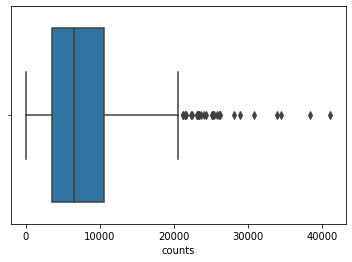

In [53]:
#station use count (by number of rides starting from that station)
station_use = data19.groupby(['start_station_code']).size().reset_index(name='counts')
use_dur = data19[['start_station_code','duration_sec']].groupby(['start_station_code']).mean().reset_index()
station_use['duration'] = use_dur['duration_sec']

station_use = station_use.merge(stations[['latitude','longitude']], how='left', left_on=['start_station_code'], right_on=['code'])
sns.boxplot(x=station_use['counts'])

In [54]:
#location of montreal
montreal = [45.5017, -73.5673]

#station popularity as a heatmap
hm = folium.Map(location=montreal, tiles='Stamen Toner', zoom_start=14)
HeatMap(data=station_use[['latitude', 'longitude', 'counts']], radius=8, max_zoom=13).add_to(hm)
hm

We can see that most trips are started downtown around the old town. 

### Which routes are the most popular?

Now instead of looking at where people start their rides, we want to look at the actual paths that are most common. This is the format we want our data in to compare to bike lane density and public transport lines. For this we create a 'paths' dataframe:

In [55]:
#create dataframe with the paths taken and the frequency as well as duration
data_sub = data19[['start_station_code','end_station_code','latitude_start','longitude_start','latitude_end','longitude_end','distance']]
paths = data19.groupby(['start_station_code','end_station_code']).size().reset_index(name='counts')
paths_dur = data19[['start_station_code','end_station_code','duration_sec']].groupby(['start_station_code','end_station_code']).mean().reset_index()
paths['duration'] = paths_dur['duration_sec']
paths = paths.merge(data_sub.drop_duplicates(), how='left', on=['start_station_code','end_station_code'])
paths.head()

,start_station_code,end_station_code,counts,duration,latitude_start,longitude_start,latitude_end,longitude_end,distance
0,4000,4000,103,1173.126214,45.549598,-73.541874,45.549598,-73.541874,0.000000
1,4000,4002,1,1864.000000,45.549598,-73.541874,45.516937,-73.640483,8.496129
2,4000,5007,1,3585.000000,45.549598,-73.541874,45.523319,-73.520127,3.377533
3,4000,6001,53,1411.509434,45.549598,-73.541874,45.510351,-73.556508,4.510499
4,4000,6002,95,504.852632,45.549598,-73.541874,45.539385,-73.541000,1.137631


We can also visualize the most frequent routes taken:

In [56]:
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

def get_arrows(locations, color='black', size=6, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill=True, fill_color=color, color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

In [136]:
#create a map with the
m = folium.Map(location=montreal, tiles='cartodbpositron', zoom_start=13)
station_pop = station_use.query('counts>15000')
for lat, lng, name, count in zip(station_pop.latitude, station_pop.longitude, station_pop.start_station_code, station_pop.counts):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=count/10000, popup=name, fill_color='red', color='red'))

vis = paths.query('counts>1000')

#plot lines between the stations according to number of trips taken
for index, row in vis.iterrows():
    folium.PolyLine([[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], color="green", weight=row['counts']/500).add_to(m) 
    arrows = get_arrows(locations=[[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], n_arrows=1)
    for arrow in arrows:
        arrow.add_to(m)
    
#put marker for end stations that are not one of the popular start stations    
filt = vis[~vis['end_station_code'].isin(station_pop['start_station_code'])]
for lat, lng, name in zip(filt.latitude_end,filt.longitude_end,filt.end_station_code):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill=True, radius=2, popup=name, fill_color='blue', color='blue'))
    
m

In [137]:
m.save("results/bike_routes")

- Red dots are one of the most popular stations to start from
- Lines are the most popular routes to take
- Blue dotes are end points which are not one of the most popular stations


# Bike friendly roads : Do they increase BIXI use?

Do people use bikes more in areas with lots of dedicated bike paths?

### General cleaning of the bike paths dataset

In [58]:
fname = "./BikePaths/reseau_cyclable_2018_c.geojson"
bp = gpd.read_file(fname)
bp.head(3)

,ID,ID_TRC_GEO,TYPE_VOIE,TYPE_VOIE2,LONGUEUR,NBR_VOIE,SEPARATEUR,SAISONS4,PROTEGE_4S,Ville_MTL,NOM_ARR_VI,geometry
0,8998.0,1230109.0,4.0,0.0,90.0,2.0,M,OUI,OUI,OUI,Le Plateau-Mont-Royal,MULTILINESTRING Z ((-73.59024 45.53259 0.00000...
1,2.0,0.0,5.0,0.0,20.0,2.0,None,NON,NON,OUI,Rivi�re-des-Prairies�Pointe-aux-Trembles,MULTILINESTRING Z ((-73.49679 45.69574 0.00000...
2,3.0,1623974.0,1.0,0.0,36.0,2.0,None,NON,NON,OUI,Rivi�re-des-Prairies�Pointe-aux-Trembles,MULTILINESTRING Z ((-73.57345 45.65853 0.00000...


In [59]:
bp = bp[bp['Ville_MTL']=='OUI']
bp = bp.reset_index(drop=True)
bp = bp.drop(columns=['ID', 'ID_TRC_GEO', 'TYPE_VOIE', 'TYPE_VOIE2', 'SEPARATEUR', 'SAISONS4', 'PROTEGE_4S', 'Ville_MTL'])

In [60]:
bp.head(3)

,LONGUEUR,NBR_VOIE,NOM_ARR_VI,geometry
0,90.0,2.0,Le Plateau-Mont-Royal,MULTILINESTRING Z ((-73.59024 45.53259 0.00000...
1,20.0,2.0,Rivi�re-des-Prairies�Pointe-aux-Trembles,MULTILINESTRING Z ((-73.49679 45.69574 0.00000...
2,36.0,2.0,Rivi�re-des-Prairies�Pointe-aux-Trembles,MULTILINESTRING Z ((-73.57345 45.65853 0.00000...


### Informations about the global dataset

In [61]:
mean_length = bp.LONGUEUR.mean()
print("Mean length of a bike path : ", np.round(mean_length, 2), " m")
sum_length = bp.LONGUEUR.sum()
print("Cumulative length of all bike paths : ", sum_length, " m")

Mean length of a bike path :  133.5  m
Cumulative length of all bike paths :  752779.0  m


In [62]:
bp_json = f'./BikePaths/reseau_cyclable_2018_c.geojson'

m_bike_json = folium.Map([45.52,-73.7], tiles='stamentoner', zoom_start=11)
folium.GeoJson(bp_json).add_to(m_bike_json)

#m_bike_json
#m_bike_json.save("results/Bike_Paths.html")

In [63]:
%%HTML
<iframe width="100%" height="350" src="results/Bike_Paths.html"></iframe>

As you can see on this map, the dedicated bicycle paths are not evenly distributed throughout Montréal. We would like to see if these dedicated paths encourage BIXI system users to cycle between two stations with more of this type of path.

### Adding individual distances between points

In [64]:
bp['distances'] = bp.apply(lambda x: np.array([]),axis=1)

In [65]:
Recompute_densities = False
if Recompute_densities:
    for k in range(len(bp)):
        distances = []
        for l in range(len(bp['geometry'][k])):
            subdistances = np.array([])
            for m in range(len(bp['geometry'][k][l].xy[0])-1):
                #distances[l] = np.append(distances[l], haversine((x.latitude_start,x.longitude_start),(x.latitude_end,x.longitude_end)))
                subdistances = np.append(subdistances, 1000*haversine((bp['geometry'][k][l].xy[1][m], bp['geometry'][k][l].xy[0][m]),(bp['geometry'][k][l].xy[1][m+1], bp['geometry'][k][l].xy[0][m+1])))
            distances.append(subdistances)
        bp['distances'][k] = np.array(distances)

In [66]:
bp = pd.read_pickle("./BikePaths/bike_paths_with_computed distances")

In [67]:
bp.head(3)

,LONGUEUR,NBR_VOIE,NOM_ARR_VI,geometry,distances
0,90.0,2.0,Le Plateau-Mont-Royal,MULTILINESTRING Z ((-73.59024 45.53259 0.00000...,[[89.74675564772875]]
1,20.0,2.0,Rivi�re-des-Prairies�Pointe-aux-Trembles,MULTILINESTRING Z ((-73.49679 45.69574 0.00000...,[[20.02003601877969]]
2,36.0,2.0,Rivi�re-des-Prairies�Pointe-aux-Trembles,MULTILINESTRING Z ((-73.57345 45.65853 0.00000...,[[35.57510452716641]]


### Bicycle path density inside a rectangle

In [68]:
def isincluded(x, y, a, b, da, db): # Attention ! da and db must be positive
    "Determines whether a point lies within the square defined by the values a, b, da and db."
    if abs(2*x - 2*a - da) <= da:
        if abs(2*y - 2*b - db) <= db:
            return 1
    return 0

In [69]:
def calculate_truncated_distance(x1, y1, x2, y2, a, b, da, db, d0, d1): # Attention ! da and db must be positive
    "For two points where one is inside the square and one is outside the square, "
    "calculate the length of the bike path portion inside the square."
    # Case where the first point is in the square
    if ((d0 == 1) and (d1 ==0)):
        if x1==x2:
            if y2<b:
                xt, yt = x1, b
            else:
                xt, yt = x1, b + db
        elif y1==y2:
            if x2<a:
                xt, yt = a, y1
            else:
                xt, yt = a + da, y1
        else:
            # Case y2 < b (under the square)
            if y2 < b:
                xtest = (x2-x1)*(b-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b
            # Case y2 > b + db (above the square)
            elif y2 > b+db:
                xtest = (x2-x1)*(b+db-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b+db
            # Case y in the range(b, b+db)
            else:
                if x2 <a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                else: # Case x2>a+da
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
        return  1000*haversine((y1,x1),(yt,xt))
    elif ((d0 == 0) and (d1 ==1)):
        return calculate_truncated_distance(x2, y2, x1, y1, a, b, da, db, d1, d0)
    else:
        return(0.)

### Example of calculation of bike path density inside a rectangle

In [70]:
### Definition of the rectangle
# Bottom left corner
b, a = 45.534745, -73.615292
# Top right corner : 45.549819, -73.583975
db = 45.549819 - b
da = -73.583975 - a

In [71]:
square = [[b, a], [b, a+da], [b+db, a+da], [b+db, a], [b, a]]
m_bike = folium.Map([45.54,-73.6], tiles='cartodbpositron', zoom_start=14)
folium.PolyLine(square, color="red", weight=2.5, opacity=1).add_to(m_bike)
m_bike

We will calculate the path density within this square. To do this, we need to know which paths are inside or outside this square.

In [72]:
def extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1): # Attention ! da and db must be positive
    "For two points where one is inside the square and the other outside, "
    "returns the point at the intersection between the edges of the square and the segment of the two points."
    # Case where the first point is in the square
    if ((d0 == 1) and (d1 ==0)):
        if x1==x2:
            if y2<b:
                xt, yt = x1, b
            else:
                xt, yt = x1, b + db
        elif y1==y2:
            if x2<a:
                xt, yt = a, y1
            else:
                xt, yt = a + da, y1
        else:
            # Case y2 < b (under the square)
            if y2 < b:
                xtest = (x2-x1)*(b-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b
            # Case y2 > b + db (above the square)
            elif y2 > b+db:
                xtest = (x2-x1)*(b+db-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b+db
            # Case y in the range(b, b+db)
            else:
                if x2 <a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                else: # Case x2>a+da
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
        return  [xt,yt]
    elif ((d0 == 0) and (d1 ==1)):
        return extremity_points(x2, y2, x1, y1, a, b, da, db, d1, d0)
    else:
        raise Error

In [73]:
### Records the portions of bicycle paths in the rectangle.
Recompute_densities = False
if Recompute_densities:
    roads_in_the_square = []
    for k in range(len(bp['geometry'])):
        for l in range(len(bp['geometry'][k])): # l et k sont les id d'un chemin simple
            # Ici, on a un chemin en considération
            subline_in_square = []
            for i in range(len(bp['geometry'][k][l].xy[0])-1): # i est l'id du point sur ce chemin
                x1, y1, x2, y2 = bp['geometry'][k][l].xy[0][i], bp['geometry'][k][l].xy[1][i] , bp['geometry'][k][l].xy[0][i+1], bp['geometry'][k][l].xy[1][i+1]
                d0, d1 = isincluded(x1, y1, a, b, da, db) , isincluded(x2, y2, a, b, da, db)
                if d0+d1==2: # Si les deux points sont dans le carré, on ajoute le premier
                    subline_in_square.append([y1, x1])
                elif d1==1: # Si seul le deuxième point est dans le carré, on ajoute l'intersection seulement
                    #print(extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1))
                    [xt, yt] = extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1)
                    subline_in_square.append([yt, xt])
                elif d0==1: # Si seul le premier point est dans le carré, on ajoute l'intersection et le premier point
                    [xt, yt] = extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1)
                    subline_in_square.append([y1, x1])
                    subline_in_square.append([yt, xt])
            if d1 == 1: # On regarde si le dernier point de la ligne doit être finalement ajouté ou non
                subline_in_square.append([y2, x2])
            if len(subline_in_square)!=0:
                roads_in_the_square.append(subline_in_square)

In [74]:
if Recompute_densities:
    square = [[b, a], [b, a+da], [b+db, a+da], [b+db, a], [b, a]]
    m_bike = folium.Map([45.54,-73.6], tiles='cartodbpositron', zoom_start=14)
    folium.PolyLine(square, color="red", weight=2.5, opacity=1).add_to(m_bike)
    for i in range(len(roads_in_the_square)):
        folium.PolyLine(roads_in_the_square[i], color='blue', weight=2.5, opacity=1).add_to(m_bike)
    m_bike

In [75]:
if Recompute_densities:
    m_bike.save("results/Example_of_bp_density_calculation.html")

In [76]:
%%HTML
<iframe width="100%" height="350" src="results/Example_of_bp_density_calculation.html"></iframe>

### Calculation of the total distance of bike lane inside the rectangle

In [77]:
if Recompute_densities:
    total_distance_in_the_square = 0.
    for k in range(len(bp['geometry'])):
        for l in range(len(bp['geometry'][k])): # l et k sont les id d'un chemin simple
            for i in range(len(bp['geometry'][k][l].xy[0])-1): # i est l'id du point sur ce chemin
                x1, y1, x2, y2 = bp['geometry'][k][l].xy[0][i], bp['geometry'][k][l].xy[1][i] , bp['geometry'][k][l].xy[0][i+1], bp['geometry'][k][l].xy[1][i+1]
                d0, d1 = isincluded(x1, y1, a, b, da, db) , isincluded(x2, y2, a, b, da, db)
                if d0+d1==2: # Si les deux points sont dans le carré, on ajoute le premier
                    total_distance_in_the_square += bp['distances'][k][l][i]
                elif ((d1==1) or (d0==1)): # Si seul le deuxième point est dans le carré, on ajoute l'intersection seulement
                    total_distance_in_the_square += calculate_truncated_distance(x1, y1, x2, y2, a, b, da, db, d0, d1)
    print("Total distance in the square computed with method 1 :",total_distance_in_the_square)
else:
    print("Total distance in the square computed with method 1 :",18567.34398641432)

Total distance in the square computed with method 1 : 18567.34398641432


### Comparison with the distance computed by the previous algorithm

In [78]:
if Recompute_densities:
    compared_distance_in_the_square = 0.
    for i in range(len(roads_in_the_square)):
        for j in range(len(roads_in_the_square[i])-1):
            compared_distance_in_the_square += 1000*haversine((roads_in_the_square[i][j][0],roads_in_the_square[i][j][1]),(roads_in_the_square[i][j+1][0],roads_in_the_square[i][j+1][1]))
    print("Total distance in the square computed with method 2 :",compared_distance_in_the_square)
else:
    print("Total distance in the square computed with method 2 :",18567.34398641432)

Total distance in the square computed with method 2 : 18567.34398641432


We are indeed achieving the same result. This means that both algorithms work well in a similar way and that there are no unintentional errors.

### Divide a big square into smaller ones and calculate density on each of them

In [79]:
def compute_density_in_squares(x1,y1,x2,y2,n_x_squares):
    '''(x1,y1) represents the point at the bottom left and (x2,y2) the point at the top right
    The n_x_squares number represents the number of squares between x1 and x2. 
    The length of a square according to x will then be used to calculate the number of squares according to y. '''
    dx = abs(x2-x1)/n_x_squares # = dy
    n_y_squares = math.ceil(abs(y2-y1)/dx)
    density_matrix = np.zeros((n_x_squares,n_y_squares))
    a, b = x1, y1
    for i in range(n_x_squares):
        for j in range(n_y_squares):
            for k in range(len(bp['geometry'])):
                for l in range(len(bp['geometry'][k])):
                    for m in range(len(bp['geometry'][k][l].xy[0])-1):
                        xp1, yp1, xp2, yp2 = bp['geometry'][k][l].xy[0][m], bp['geometry'][k][l].xy[1][m] , bp['geometry'][k][l].xy[0][m+1], bp['geometry'][k][l].xy[1][m+1]
                        d0, d1 = isincluded(xp1, yp1, a, b, dx, dx) , isincluded(xp2, yp2, a, b, dx, dx)
                        if d0+d1==2: # If the two points are in the square
                            density_matrix[i,j] += bp['distances'][k][l][m]
                        elif ((d1==1) or (d0==1)): # If only one point is in the square
                            density_matrix[i,j] += calculate_truncated_distance(xp1, yp1, xp2, yp2, a, b, dx, dx, d0, d1)
            b+=dx
        a += dx
        b = y1
    for i in range(n_x_squares):
        for j in range(n_y_squares):
            density_matrix[i,j] = density_matrix[i,j]/((haversine((y1, x1), (y1+dx, x1+dx)))**2)
    return density_matrix

In [80]:
# density_matrix_test = compute_density_in_squares(-73.662333, 45.470386, -73.534273, 45.571657, 10)

In [81]:
# Loading previous result

density_matrix_test = np.array([[   0.        ,    0.        ,    0.        ,   15.89333367,
           0.        ,    0.        , 1831.37103444,  760.9496764 ],
       [ 325.91864594,  607.82249553,  402.55594107,    0.        ,
         458.60720575,  486.66586539, 1804.97789517, 1040.38438051],
       [1200.03785482,  988.64313558,  803.27878942,  317.75461762,
        1026.16893779, 1804.05003034,  868.81719987, 1346.43251843],
       [ 748.58840031,  128.37707621,  924.90397643,  865.78998026,
         292.5099289 , 2597.36025776,  831.16538798,  419.53643211],
       [ 696.6549423 ,  105.83030859,  464.91099804, 1112.99580186,
        2149.41216313, 2265.98327835, 1440.92925419,  317.40214762],
       [ 503.43596322,   34.42215485, 1728.48237621, 2120.97759095,
        2475.89595888, 1720.20413968, 2674.76342619,  676.25795522],
       [1686.27369518,  511.15319819, 1160.10354596, 3015.30741535,
        2476.38055347, 2992.32816772, 2489.01619164, 2451.0126901 ],
       [1882.84258311, 1063.98418081,  882.1530329 , 1447.47836826,
        1694.54853976, 1764.72761934,  934.85697661, 1841.40052721],
       [1002.7295195 , 1662.00198248, 1546.52643377, 1247.18203521,
        1606.89500269,  899.91636181, 1858.00776144, 1387.02945754],
       [ 637.19371826,  307.61141929,  858.04126216,  187.64247536,
         693.61227061, 1688.59445133, 2182.55238712,  452.70474823]])

### Preparing a chloropleth

In [82]:
# Match each item in the density_matrix list with its corresponding square.

def edges_of_the_squares(x1,y1,x2,y2,n_x_squares):
    '''(x1,y1) represents the point at the bottom left and (x2,y2) the point at the top right
    The n_x_squares number represents the number of squares between x1 and x2. 
    The length of a square according to x will then be used to calculate the number of squares according to y. '''
    dx = abs(x2-x1)/n_x_squares # = dy
    n_y_squares = math.ceil(abs(y2-y1)/dx)
    edges_matrix = np.array([[((y1+j*dx, x1+i*dx), (y1+j*dx, x1+i*dx+dx), (y1+j*dx+dx, x1+i*dx+dx), (y1+j*dx+dx, x1+i*dx), (y1+j*dx, x1+i*dx)) for j in range(n_y_squares)] for i in range(n_x_squares)])
    # Similarly to [[b, a], [b, a+da], [b+db, a+da], [b+db, a], [b, a]] above
    return edges_matrix

In [83]:
edges_matrix_test = edges_of_the_squares(-73.662333, 45.470386, -73.534273, 45.571657, 10)

In [84]:
"""This cell is used to create the grid that will be used for the chloropleth, in geojson format."""

for i in range(edges_matrix_test.shape[0]):
    for j in range(edges_matrix_test.shape[1]):
        for k in range(edges_matrix_test.shape[2]):
            edges_matrix_test[i,j,k,0], edges_matrix_test[i,j,k,1] = edges_matrix_test[i,j,k,1], edges_matrix_test[i,j,k,0]

id_list = [[]]
for j in range(edges_matrix_test.shape[1]):
    id_list[0].append(str(i)+"-"+str(j))
for i in range(1,edges_matrix_test.shape[0]):
    id_list.append([])
    for j in range(edges_matrix_test.shape[1]):
        id_list[i].append(str(i)+"-"+str(j))
        
def convert_to_geojson(data):
    dump = {}
    dump["type"] = "FeatureCollection"
    
    features = []
    for id, points in data :
        if points[0] != points[-1]:
            print("invalid points !", points)
        feature = {"id":id}
        feature["type"] = "Feature"
        feature["properties"] = {"id":id}
        feature["geometry"] = {"type":"Polygon", "coordinates":[points,]}
        features.append(feature)
    dump["features"] = features
    return json.dumps(dump)

id_and_squares = [(id_list[i][j], edges_matrix_test[i][j].tolist()) for j in range(edges_matrix_test.shape[1]) for i in range(edges_matrix_test.shape[0])]

montreal_squares = convert_to_geojson(id_and_squares)

In [85]:
distances_in_the_squares = pd.DataFrame({'id':np.array(id_list).flatten(), 'density':density_matrix_test.flatten()})

### Choropleth of the bike path densities

In [86]:
m_bike = folium.Map([45.52,-73.6], tiles='cartodbpositron', zoom_start=12)

folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='BuPu',
    fill_opacity=0.4,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bike)


m_bike

In [87]:
m_bike.save("results/Bike_Path_Density_Chloropleth.html")

### HeatMap of bike turning points

In [88]:
data_pointsx = np.array([])
data_pointsy = np.array([])
for k in range(len(bp['geometry'])):
    for l in range(len(bp['geometry'][k])):
        data_pointsx = np.append(data_pointsx, bp['geometry'][k][l].xy[0])
        data_pointsy = np.append(data_pointsy, bp['geometry'][k][l].xy[1])
data_points = np.vstack((data_pointsy, data_pointsx)).T

In [89]:
m_bike_points = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
HeatMap(data_points, radius = 15, min_opacity = 0.6).add_to(m_bike_points)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bike_points)
m_bike_points

In [90]:
m_bike_points.save("results/Matching_Bike_Path_Density_Chloropleth_with_Point_Density.html")

These densities are well consistent with the point density for each road segment. However, we needed to calculate this density because the number of points can often differ from the length of a path: a circular path will have many more points than a long straight line.

### Comparison of the bike path density and the density of BIXI stations

In [91]:
stations = pd.read_csv('./BixiMontrealRentals/Stations_2019.csv', sep=',').set_index('code')

station_pointsx = np.array(stations.longitude.array)
station_pointsy = np.array(stations.latitude.array)
station_points = np.vstack((station_pointsy, station_pointsx)).T

m_bixi_bp = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bixi_bp)
HeatMap(station_points, radius = 12, min_opacity = 1).add_to(m_bixi_bp)
m_bixi_bp

### Compute bike path density between two BIXI stations

In [92]:
bixi_paths = pd.read_pickle("paths")
bixi_paths.head(3)

,start_station_code,end_station_code,counts,duration,latitude_start,longitude_start,latitude_end,longitude_end,distance
0,4000,4000,103,1173.126214,45.549598,-73.541874,45.549598,-73.541874,0.000000
1,4000,4002,1,1864.000000,45.549598,-73.541874,45.516937,-73.640483,8.496129
2,4000,5007,1,3585.000000,45.549598,-73.541874,45.523319,-73.520127,3.377533


In [93]:
bixi_paths = bixi_paths.sort_values(by="counts", axis=0)
bixi_paths = bixi_paths.dropna()
bixi_paths = bixi_paths[bixi_paths['distance']>0.]

In [94]:
bixi_subdata = bixi_paths[(bixi_paths['counts']>=500)].sample(200)

cut_counts_list = [0, 10, 20, 40, 100, 500]
for k in range(len(cut_counts_list)-1):
    bixi_subdata = pd.concat([bixi_subdata, bixi_paths[(bixi_paths['counts']>=cut_counts_list[k])&(bixi_paths['counts']<cut_counts_list[k+1])].sample(200)])

bixi_subdata = bixi_subdata.reset_index(drop=True)
bixi_subdata['bp_density'] = bixi_subdata.apply(lambda x: 0.,axis=1)
"""
for k in bixi_subdata.index:
    bixi_subdata['bp_density'][k] = compute_density_in_squares(bixi_subdata['longitude_start'][k],bixi_subdata['latitude_start'][k],bixi_subdata['longitude_end'][k],bixi_subdata['latitude_end'][k])
"""

"\nfor k in bixi_subdata.index:\n    bixi_subdata['bp_density'][k] = compute_density_in_squares(bixi_subdata['longitude_start'][k],bixi_subdata['latitude_start'][k],bixi_subdata['longitude_end'][k],bixi_subdata['latitude_end'][k])\n"

In [95]:
# After the analysis (around 2.5 hours to run)
bixi_subdata  = pd.read_pickle("./paths_with_bp_densities")

In [96]:
bixi_subdata.head(2)

,start_station_code,end_station_code,counts,duration,latitude_start,longitude_start,latitude_end,longitude_end,distance,bp_density
0,6387,4000,540,367.100000,45.546907,-73.551557,45.549598,-73.541874,0.811189,2.580871
1,6727,10002,1015,398.568473,45.484081,-73.560918,45.478228,-73.569651,0.941929,2.547097


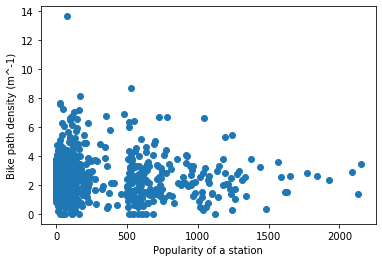

In [97]:
plt.scatter(bixi_subdata.counts, bixi_subdata.bp_density)
plt.ylabel('Bike path density (m^-1)')
plt.xlabel('Popularity of a station')
plt.show()

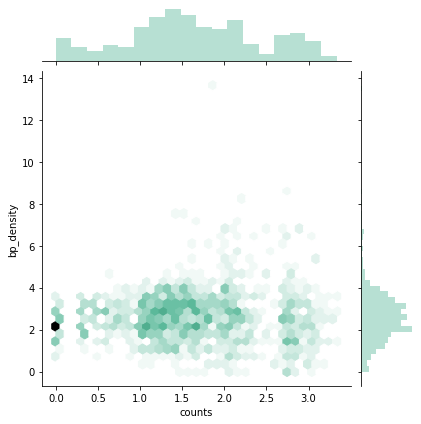

In [98]:
sns.jointplot(np.log10(bixi_subdata.counts), bixi_subdata.bp_density, kind='hex', color="#4CB391")

In [99]:
print("Correlation coefficient between the density of bicycle paths in the vicinity and the popularity of the same road: ")
print(bixi_subdata.counts.corr(bixi_subdata.bp_density))

Correlation coefficient between the density of bicycle paths in the vicinity and the popularity of the same road: 
-0.05794804683459805


The frequency of use of a particular path is not correlated here with the density of dedicated bicycle paths. The bike-friendliness of a road therefore has little impact on the frequency with which it is used.

# Integration into Public Transport

In [100]:
fname = "./BusLines/stm_lignes_sig.shp"
busl = gpd.read_file(fname)

### Metro lines

In [101]:
m_metro = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_metro)
folium.GeoJson(busl[:9],name='route_name').add_to(m_metro)
m_metro

In [102]:
m_metro.save("results/Matching_Bike_Path_Density_Chloropleth_Metro_Lines.html")

### Bus lines

In [103]:
m_bus = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bus)
folium.GeoJson(busl[10:491], style_function= lambda x :{'color': 'green','opacity':0.2}).add_to(m_bus)
#m_bus

In [104]:
#m_bus.save("results/Matching_Bike_Path_Density_Chloropleth_Bus_Lines.html")

In [105]:
%%HTML
<iframe width="100%" height="350" src="results/Matching_Bike_Path_Density_Chloropleth_Bus_Lines.html"></iframe>

### Compare Bixi station locations with Metro and Bus locations

In [106]:
stations = pd.read_csv('./BixiMontrealRentals/Stations_2019.csv', sep=',').set_index('code')

station_pointsx = np.array(stations.longitude.array)
station_pointsy = np.array(stations.latitude.array)
station_points = np.vstack((station_pointsy, station_pointsx)).T

m_metro_2 = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
HeatMap(station_points, radius = 10, min_opacity = 0.8).add_to(m_metro_2)
folium.GeoJson(busl[:9],name='route_name', style_function= lambda x :{'color': 'red','opacity':3}).add_to(m_metro_2)
m_metro_2

In [107]:
m_metro_2.save("results/Matching_Bixi_Stations_HeatMap-with_Metro_Lines.html")

In [108]:
m_bus_2 = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
HeatMap(station_points, radius = 10, min_opacity = 0.8).add_to(m_bus_2)
folium.GeoJson(busl[10:491], style_function= lambda x :{'color': 'green','opacity':0.2}).add_to(m_bus_2)
#m_bus_2

In [109]:
#m_bus_2.save("results/Matching_Bixi_Stations_HeatMap_with_Bus_Lines.html")

In [110]:
%%HTML
<iframe width="100%" height="350" src="results/Matching_Bixi_Stations_HeatMap_with_Bus_Lines.html"></iframe>

In [119]:
mpath = folium.Map(location=montreal, tiles='cartodbpositron', zoom_start=12)

vis = paths.query('counts>600')

#plot lines between the stations according to number of trips taken
for index, row in vis.iterrows():
    folium.PolyLine([[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], color="blue", weight=row['counts']/500).add_to(mpath) 


folium.GeoJson(busl[:9],name='route_name', style_function= lambda x :{'color': 'red','opacity':3}).add_to(mpath)

    
mpath

In [120]:
mpath.save("results/metro_routes.html")

In [133]:
mbb = folium.Map(location=montreal, tiles='cartodbpositron', zoom_start=11)

#plot lines between the stations according to number of trips taken
for index, row in vis.iterrows():
    folium.PolyLine([[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], color="red", weight=row['counts']/500).add_to(mbb) 

folium.GeoJson(busl[10:491], style_function= lambda x :{'color': 'green','opacity':0.2}).add_to(mbb)

In [134]:
mbb.save("results/bus_routes.html")

In [135]:
%%HTML
<iframe width="100%" height="350" src="results/bus_routes.html"></iframe>

# Correlation with Weather